In [16]:
# ref to https://github.com/fczhang0606/4.1-Graph-Neural-Networks/tree/main

In [17]:
# ! pip install scipy
# ! pip install scikit-learn

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from collections import namedtuple
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import os.path as osp
import pickle
import scipy.sparse as sp
from sklearn.manifold import TSNE
import urllib

In [19]:
# 自制格式
Data = namedtuple('Data', ['x', 'y', 'adjacency', 'train_mask', 'val_mask', 'test_mask'])


def tensor_from_numpy(x, device) :
    return torch.from_numpy(x).to(device)


class CoraData(object) :

    # https://blog.csdn.net/zfhsfdhdfajhsr/article/details/116137598
    filenames = ["ind.cora.{}".format(name) 
                 for name in ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']]

    def __init__(self, data_root=
                 "../data", 
                 rebuild=False) :

        """Cora数据，包括数据下载、处理、加载等功能
        当数据的缓存文件存在时，将使用缓存文件，否则将下载、进行处理，并缓存到磁盘

        处理之后的数据，可以通过属性 .data 获得，它将返回一个数据对象，包括如下几部分：（和原始下载不一致）
            * x: 全节点的特征，维度为 2708 * 1433 ，类型为 np.ndarray
            * y: 全节点的标签，维度为 2708 * 7 ，one-hot，类型为 np.ndarray
            * adjacency: 邻接矩阵，维度为 2708 * 2708 ，类型为 scipy.sparse.coo.coo_matrix
            * train_mask: 训练集掩码向量，维度为 2708*1 ，当节点属于训练集时，相应位置为True，否则False
            * val_mask: 验证集掩码向量，维度为 2708*1   ，当节点属于验证集时，相应位置为True，否则False
            * test_mask: 测试集掩码向量，维度为 2708*1  ，当节点属于测试集时，相应位置为True，否则False

        Args:
        ------
            data_root: string, optional
                存放数据的目录，原始数据路径: ..
                缓存数据路径: {data_root}/ch5_cached.pkl
            rebuild: boolean, optional
                是否需要重新构建数据集，当设为True时，如果存在缓存数据也会重建数据
        """

        self.data_root = data_root
        save_file = osp.join(self.data_root, "ch5_cached.pkl")
        if osp.exists(save_file) and not rebuild :
            print("using cached file: {}".format(save_file))
            self._data = pickle.load(open(save_file, "rb"))
        else :
            self._data = self.process_data()
            with open(save_file, "wb") as f :
                pickle.dump(self.data, f)  # 为什么不直接self._data?
            print("cached file: {}".format(save_file))

    @property  # 装饰器
    def data(self) :
        """返回Data数据对象，包括x、y、adjacency、train_mask、val_mask、test_mask"""
        return self._data

    def process_data(self) :

        """
        处理数据，得到节点特征、标签、邻接矩阵、训练集、验证集以及测试集
        引用自： https://github.com/rusty1s/pytorch_geometric
        """

        print("Process data ...")

        _, tx, allx, y, ty, ally, graph, test_index = [self.read_data(
            osp.join(self.data_root, name)) for name in self.filenames]

        train_index = np.arange(y.shape[0])  # 此处的y不是缓存data当中的全y，只有140个标签
        val_index = np.arange(y.shape[0], y.shape[0] + 500)  # 140～640
        sorted_test_index = sorted(test_index)  # 读取的值

        x = np.concatenate((allx, tx), axis=0)  # 构建全集
        y = np.concatenate((ally, ty), axis=0).argmax(axis=1)

        x[test_index] = x[sorted_test_index]
        y[test_index] = y[sorted_test_index]
        num_nodes = x.shape[0]  # 2708

        train_mask = np.zeros(num_nodes, dtype=np.bool_)
        val_mask   = np.zeros(num_nodes, dtype=np.bool_)
        test_mask  = np.zeros(num_nodes, dtype=np.bool_)

        train_mask[train_index] = True
        val_mask[val_index]     = True
        test_mask[test_index]   = True

        adjacency = self.build_adjacency(graph)

        print("Node's feature shape: ", x.shape)  # 2708 x 1433
        print("Node's label shape: ", y.shape)  # 2708 x 7
        print("Adjacency's shape: ", adjacency.shape)  # 2708 x 2708
        print("Number of training nodes: ", train_mask.sum())  # 140
        print("Number of validation nodes: ", val_mask.sum())  # 500
        print("Number of test nodes: ", test_mask.sum())  # 1000

        return Data(x=x, y=y, adjacency=adjacency, 
                    train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

    @staticmethod
    def build_adjacency(adj_dict) :
        """根据邻接表创建邻接阵"""

        edge_index = []
        num_nodes = len(adj_dict)  # 表长
        for src, dst in adj_dict.items() :  # 有向
            edge_index.extend([src, v] for v in dst)
            edge_index.extend([v, src] for v in dst)

        # 去除重复的边
        edge_index = list(k for k, _ in itertools.groupby(sorted(edge_index)))  # 重排
        edge_index = np.asarray(edge_index)  # 转换类型
        adjacency = sp.coo_matrix(
                    ( np.ones(len(edge_index)), (edge_index[:, 0], edge_index[:, 1]) ), 
                    shape=(num_nodes, num_nodes), dtype="float32")  # 1放在哪里
        return adjacency

    @staticmethod
    def read_data(path) :
        """使用不同的方式读取原始数据以进一步处理"""
        name = osp.basename(path)
        if name == "ind.cora.test.index" :
            out = np.genfromtxt(path, dtype="int64")
            return out
        else :
            out = pickle.load(open(path, "rb"), encoding="latin1")
            out = out.toarray() if hasattr(out, "toarray") else out
            return out

    @staticmethod
    def normalization(adjacency) :
        """计算 L = (D^-0.5) * (A+I) * (D^-0.5)"""
        adjacency += sp.eye(adjacency.shape[0])  # 增加identity
        degree = np.array(adjacency.sum(1))
        d_hat = sp.diags(np.power(degree, -0.5).flatten())
        return d_hat.dot(adjacency).dot(d_hat).tocoo()

In [20]:
class GraphConvolution(nn.Module) :

    def __init__(self, input_dim, output_dim, use_bias=True) :

        """图卷积：L*X*\theta

        Args:
        ------
            input_dim: int
                节点输入特征的维度
            output_dim: int
                节点输出特征的维度
            use_bias: bool, optional
                是否使用偏置
        """

        super(GraphConvolution, self).__init__()

        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.use_bias   = use_bias
        self.weight     = nn.Parameter(torch.Tensor(input_dim, output_dim))  # 参数

        if self.use_bias :
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else :
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) :
        init.kaiming_uniform_(self.weight)
        if self.use_bias :
            init.zeros_(self.bias)

    def forward(self, adjacency, input_feature) :

        """邻接矩阵是稀疏矩阵，因此在计算时使用稀疏矩阵乘法

        Args:
        ------
            adjacency: torch.sparse.FloatTensor  # ???
                邻接矩阵
            input_feature: torch.Tensor
                输入特征
        """

        support = torch.mm(input_feature.cpu(), self.weight.cpu())
        output = torch.sparse.mm(adjacency.cpu(), support.cpu())  # 矩阵结合律
        output = output.cpu()
        if self.use_bias :
            output += self.bias
        return output

    def __repr__(self) :
        return self.__class__.__name__ + '('    \
            + str(self.input_dim)      + ' -> ' \
            + str(self.output_dim)     + ')'

In [21]:
class Model(nn.Module) :

    """
    定义一个包含两层GraphConvolution的模型
    """

    def __init__(self, input_dim=1433) :
        super(Model, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, 16)
        self.gcn2 = GraphConvolution(16, 7)

    def forward(self, adjacency, feature) :
        h = F.relu(self.gcn1(adjacency, feature))
        logits = self.gcn2(adjacency, h)
        return logits  # logistic units

In [22]:
# 超参数定义
LEARNING_RATE = 0.1
WEIGHT_DACAY = 5e-4
EPOCHS = 200
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())

False


In [23]:
# 加载数据，并转换为torch.Tensor
dataset = CoraData().data

# feature - label
node_feature = dataset.x / dataset.x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1
tensor_x     = tensor_from_numpy(node_feature, DEVICE)
tensor_y     = tensor_from_numpy(dataset.y, DEVICE)

# mask
tensor_train_mask = tensor_from_numpy(dataset.train_mask, DEVICE)
tensor_val_mask   = tensor_from_numpy(dataset.val_mask, DEVICE)
tensor_test_mask  = tensor_from_numpy(dataset.test_mask, DEVICE)

# A
normalize_adjacency = CoraData.normalization(dataset.adjacency)  # 规范化邻接矩阵

# sparse A
num_nodes, input_dim = node_feature.shape  # 2708 x 1433
indices = torch.from_numpy(np.asarray([normalize_adjacency.row, 
                                       normalize_adjacency.col]).astype('int64')).long()
values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency = torch.sparse.FloatTensor(indices, values, 
                                            (num_nodes, num_nodes)).to(DEVICE)

using cached file: ../data/ch5_cached.pkl


In [24]:
# setup
model = Model(input_dim).to(DEVICE)

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DACAY)

In [25]:

# 训练主体
def train() :

    model.train()  # nn模式

    loss_history    = []
    val_acc_history = []

    train_y = tensor_y[tensor_train_mask]  # 训练集的label

    for epoch in range(EPOCHS) :

        optimizer.zero_grad()
        logits = model(tensor_adjacency, tensor_x)  # 前向传播
        train_mask_logits = logits[tensor_train_mask]  # 只选训练节点进行监督
        loss = criterion(train_mask_logits, train_y)  # loss
        loss.backward()  # 反向传播计算参数梯度
        optimizer.step()  # 使用优化方法进行梯度更新

        train_acc, _, _ = test(tensor_train_mask)  # 计算当前模型在训练集上的准确率
        val_acc, _, _   = test(tensor_val_mask)  # 计算当前模型在验证集上的准确率

        # 记录训练过程中，损失值和准确率的变化，用于画图
        loss_history.append(loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}, ValAcc {:.4f}".
              format(epoch, loss.item(), train_acc.item(), val_acc.item()))

    return loss_history, val_acc_history

In [26]:
# 测试主体
def test(mask) :

    model.eval()  ## nn模式

    with torch.no_grad() :  # 当前计算不需要反向传播

        logits = model(tensor_adjacency, tensor_x)  # 当前参数
        test_mask_logits = logits[mask]
        predict_y = test_mask_logits.max(1)[1]  # 取值最大预测概率类别
        accuarcy = torch.eq(predict_y, tensor_y[mask]).float().mean()

    return accuarcy, test_mask_logits.cpu().numpy(), tensor_y[mask].cpu().numpy()

In [27]:
# 画图
def plot_loss_and_acc(loss_history, val_acc_history) :

    fig = plt.figure()

    ax1 = fig.add_subplot(111)  # 画布分为n*n，n号区
    ax1.plot(range(len(loss_history)), loss_history, 
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')

    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    ax2.plot(range(len(val_acc_history)), val_acc_history, 
             c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel('ValAcc')

    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()

In [28]:
loss, val_acc = train()
test_acc, test_logits, test_label = test(tensor_test_mask)
print("Test accuarcy: ", test_acc.item())

Epoch 000: Loss 1.9569, TrainAcc 0.2571, ValAcc 0.2240
Epoch 001: Loss 1.9126, TrainAcc 0.3143, ValAcc 0.1920
Epoch 002: Loss 1.8363, TrainAcc 0.5143, ValAcc 0.3180
Epoch 003: Loss 1.7484, TrainAcc 0.4786, ValAcc 0.2720
Epoch 004: Loss 1.6530, TrainAcc 0.7357, ValAcc 0.4100
Epoch 005: Loss 1.5304, TrainAcc 0.8714, ValAcc 0.5760
Epoch 006: Loss 1.3966, TrainAcc 0.8929, ValAcc 0.6000
Epoch 007: Loss 1.2608, TrainAcc 0.9357, ValAcc 0.7100
Epoch 008: Loss 1.1138, TrainAcc 0.9643, ValAcc 0.7480
Epoch 009: Loss 0.9705, TrainAcc 0.9571, ValAcc 0.7520
Epoch 010: Loss 0.8419, TrainAcc 0.9786, ValAcc 0.7680
Epoch 011: Loss 0.7223, TrainAcc 0.9857, ValAcc 0.7640
Epoch 012: Loss 0.6189, TrainAcc 0.9929, ValAcc 0.7740
Epoch 013: Loss 0.5340, TrainAcc 0.9857, ValAcc 0.7900
Epoch 014: Loss 0.4610, TrainAcc 0.9929, ValAcc 0.7920
Epoch 015: Loss 0.4030, TrainAcc 0.9929, ValAcc 0.7960
Epoch 016: Loss 0.3576, TrainAcc 0.9929, ValAcc 0.7880
Epoch 017: Loss 0.3207, TrainAcc 0.9929, ValAcc 0.7920
Epoch 018:

[1.956872820854187, 1.912619709968567, 1.8362537622451782, 1.7484391927719116, 1.6529713869094849, 1.530355453491211, 1.3966467380523682, 1.26077401638031, 1.1137685775756836, 0.9705265760421753, 0.8418655395507812, 0.7223043441772461, 0.6189219355583191, 0.5339746475219727, 0.4610387980937958, 0.4029669761657715, 0.35756853222846985, 0.32072535157203674, 0.2922954559326172, 0.27137359976768494, 0.25541988015174866, 0.24296270310878754, 0.23512208461761475, 0.22878001630306244, 0.22256839275360107, 0.21833813190460205, 0.21321608126163483, 0.2071574181318283, 0.20158934593200684, 0.19469031691551208, 0.18740206956863403, 0.18097864091396332, 0.17416082322597504, 0.16821764409542084, 0.16316300630569458, 0.15835769474506378, 0.15473581850528717, 0.15153980255126953, 0.149000883102417, 0.14681369066238403, 0.14483168721199036, 0.1431799679994583, 0.14148898422718048, 0.14067789912223816, 0.14142531156539917, 0.1441057175397873, 0.14177864789962769, 0.13172580301761627, 0.1338192969560623

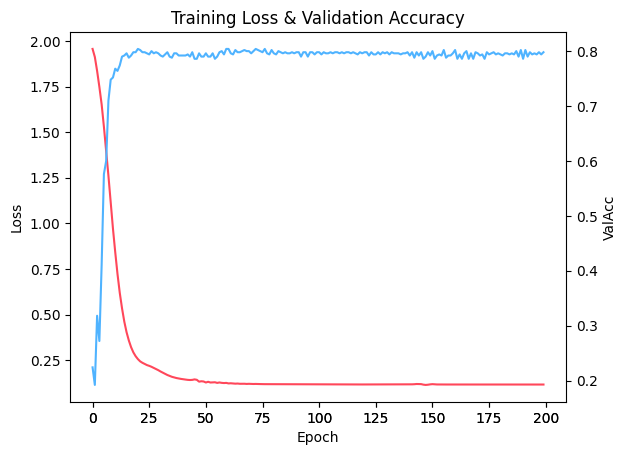

In [29]:
print(loss)
plot_loss_and_acc(loss, val_acc)

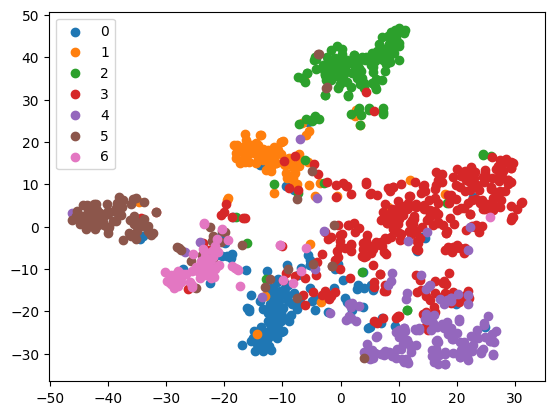

In [30]:
# 绘制测试数据的TSNE降维图

tsne = TSNE()
out = tsne.fit_transform(test_logits)

fig = plt.figure()
for i in range(7) :
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))

plt.legend()